## Testing methods for resizing images: Bilinear, Nearest, Bicubic, Box, Hamming, Lanczos

### Imports

In [10]:
import sys
sys.path.append('D:/GitHub/Mariuki/DiseaseDetector/Detector de Padecimientos Rayos-X Torax - Codigo')
sys.path

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import pathlib
import albumentations as A
import numpy as np

from datasets import ObjectDetectionDataSet
from transformations import ComposeDouble, Clip, AlbumentationWrapper, FunctionWrapperDouble, normalize_01, RescaleWithBB
from utils import get_filenames_of_path, read_json, read_pt, collate_double, save_json

import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.models.detection.transform import GeneralizedRCNNTransform

from visual import DatasetViewer
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
%matplotlib qt
# %matplotlib inline

### Loading images and labels

In [4]:
# directorio
root = pathlib.Path("../data/ChestXRay8/1024")

# Entradas (imágenes) y Objetivos (etiquetas)
inputs = get_filenames_of_path(root / 'ChestBBImages')
targets = get_filenames_of_path(root / 'ChestBBLabels')

inputs.sort()
targets.sort()

# Mapeo de etiquetas a enteros
mapping = read_json(pathlib.Path('LabelsMappping.json'))
mapping

cmap = plt.cm.get_cmap('gist_rainbow', 8)
crgb =  [cmap(i)[:3] for i in range(cmap.N)]
mappingR = {v:k for k,v in mapping.items()}
mappingC = {j:crgb[i] for i, j in enumerate(mapping.keys())}

## Transformaciones y creación de datasets

In [5]:
# import torchvision.transforms as T
# type(datasetBL[1]['x'])
# type(T.ToTensor()(T.ToPILImage()(datasetBL[1]['x'])))
# T.Resize([128,128],interpolation = T.InterpolationMode.HAMMING)(T.ToPILImage()(datasetBL[1]['x']))
# T.Resize([128,128],interpolation = T.InterpolationMode.HAMMING)(datasetBL[1]['x'])
#------------------------- Bilinear ----------------------------#
transformsBL = ComposeDouble([
    Clip(),
    FunctionWrapperDouble(normalize_01),
    RescaleWithBB([256],'bilinear')
    ])
# Conjunto de datos
datasetBL = ObjectDetectionDataSet(inputs=inputs,
                                   targets=targets,
                                   transform=transformsBL,
                                   add_dim = 3,
                                   use_cache=False,
                                   convert_to_format=None,
                                   mapping=mapping,
                                   # metadata_dir='ChestX-ray8-Data/Data_Entry_2017_v2020.csv',
                                   # filters = [[op.gt,'Patient Age',10],[op.lt,'Patient Age',81]],
                                   id_column = 'Image Index')
#------------------------- Nearest ----------------------------#
transformsN = ComposeDouble([
    Clip(),
    FunctionWrapperDouble(normalize_01),
    RescaleWithBB([256],'nearest')
    ])
# Conjunto de datos
datasetN = ObjectDetectionDataSet(inputs=inputs,
                                  targets=targets,
                                  transform=transformsN,
                                  add_dim = 3,
                                  use_cache=False,
                                  convert_to_format=None,
                                  mapping=mapping,
                                  # metadata_dir='ChestX-ray8-Data/Data_Entry_2017_v2020.csv',
                                  # filters = [[op.gt,'Patient Age',10],[op.lt,'Patient Age',81]],
                                  id_column = 'Image Index')
#------------------------- Bicubic ----------------------------#
transformsBC = ComposeDouble([
    Clip(),
    FunctionWrapperDouble(normalize_01),
    RescaleWithBB([256],'bicubic')
    ])
# Conjunto de datos
datasetBC = ObjectDetectionDataSet(inputs=inputs,
                                   targets=targets,
                                   transform=transformsBC,
                                   add_dim = 3,
                                   use_cache=False,
                                   convert_to_format=None,
                                   mapping=mapping,
                                   # metadata_dir='ChestX-ray8-Data/Data_Entry_2017_v2020.csv',
                                   # filters = [[op.gt,'Patient Age',10],[op.lt,'Patient Age',81]],
                                   id_column = 'Image Index')
#------------------------- Box ----------------------------#
transformsBX = ComposeDouble([
    Clip(),
    FunctionWrapperDouble(normalize_01),
    RescaleWithBB([256],'box')
    ])
# Conjunto de datos
datasetBX = ObjectDetectionDataSet(inputs=inputs,
                                   targets=targets,
                                   transform=transformsBX,
                                   add_dim = 3,
                                   use_cache=False,
                                   convert_to_format=None,
                                   mapping=mapping,
                                   # metadata_dir='ChestX-ray8-Data/Data_Entry_2017_v2020.csv',
                                   # filters = [[op.gt,'Patient Age',10],[op.lt,'Patient Age',81]],
                                   id_column = 'Image Index')
#------------------------- Hamming ----------------------------#
transformsH = ComposeDouble([
    Clip(),
    FunctionWrapperDouble(normalize_01),
    RescaleWithBB([256],'hamming')
    ])
# Conjunto de datos
datasetH = ObjectDetectionDataSet(inputs=inputs,
                                  targets=targets,
                                  transform=transformsH,
                                  add_dim = 3,
                                  use_cache=False,
                                  convert_to_format=None,
                                  mapping=mapping,
                                  # metadata_dir='ChestX-ray8-Data/Data_Entry_2017_v2020.csv',
                                  # filters = [[op.gt,'Patient Age',10],[op.lt,'Patient Age',81]],
                                  id_column = 'Image Index')
#------------------------- Lanczos ----------------------------#
transformsL = ComposeDouble([
    Clip(),
    FunctionWrapperDouble(normalize_01),
    RescaleWithBB([256],'lanczos')
    ])
# Conjunto de datos
datasetL = ObjectDetectionDataSet(inputs=inputs,
                                  targets=targets,
                                  transform=transformsL,
                                  add_dim = 3,
                                  use_cache=False,
                                  convert_to_format=None,
                                  mapping=mapping,
                                  # metadata_dir='ChestX-ray8-Data/Data_Entry_2017_v2020.csv',
                                  # filters = [[op.gt,'Patient Age',10],[op.lt,'Patient Age',81]],
                                  id_column = 'Image Index')

## Visualización de resultados

In [6]:
#--------- visor matplotlib -----------#
class IndexTracker:
    def __init__(self, ax, X):
        self.ax = ax
        print(self.ax.shape[0])
        fig.suptitle('Diferentes interpolaciones para redimensionado', fontsize=16)

        self.X = X
        self.slices = len(self.X[0])
        self.ind = 0 #self.slices//2
        self.ims = []
        self.intermets = ['Bilinear', 'Nearest', 'Bicubic', 'Box', 'Hamming', 'Lanczos']
        count = -1
        for r in range(self.ax.shape[0]):
            for c in range(self.ax.shape[1]):
                count += 1
                self.ax[r,c].set_title('{}'.format(self.intermets[count]))

        # self.im = ax.imshow(self.X[:, :, self.ind])
        # self.im = ax[0].imshow(torch.moveaxis(self.X[self.ind]['x'], 0,-1))
        count = -1
        for r in range(self.ax.shape[0]):
            for c in range(self.ax.shape[1]):
                count += 1
                self.ims.append(ax[r,c].imshow(torch.moveaxis(self.X[count][self.ind]['x'], 0,-1)))
                for box,lab in zip(self.X[count][self.ind]['y']['boxes'], self.X[count][self.ind]['y']['labels']):
                    ax[r,c].add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor=mappingC[mappingR[int(lab)]], facecolor='none'))
                ax[r,c].patches = []
        self.update()

    def on_scroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        for r in range(self.ax.shape[0]):
            for c in range(self.ax.shape[1]):
                ax[r,c].patches = []
        self.update()

    def update(self):
        # self.im.set_data(self.X[:, :, self.ind])
        # self.im.set_data(torch.moveaxis(self.X[self.ind]['x'], 0,-1))
        count = -1
        for r in range(self.ax.shape[0]):
            for c in range(self.ax.shape[1]):
                count += 1
                self.ims[count].set_data(torch.moveaxis(self.X[count][self.ind]['x'], 0,-1))
                for box,lab in zip(self.X[count][self.ind]['y']['boxes'], self.X[count][self.ind]['y']['labels']):
                    ax[r,c].add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor=mappingC[mappingR[int(lab)]], facecolor='none'))
                self.ax[r,c].set_ylabel('Image: %s' % self.X[count][self.ind]['x_name'])
                self.ims[count].axes.figure.canvas.draw()

2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


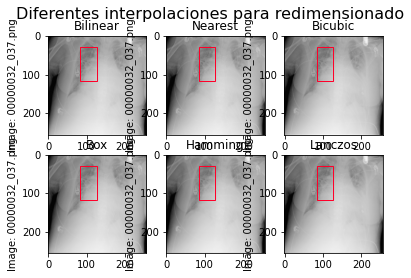

In [9]:
fig, ax = plt.subplots(2, 3)
tracker = IndexTracker(ax, [datasetBL, datasetN, datasetBC, datasetBX, datasetH, datasetL])

fig.canvas.mpl_connect('scroll_event', tracker.on_scroll)
plt.show()

## Visualización de resultados con napari

In [13]:
# Crear cargador de datos
dataloader = DataLoader(dataset=datasetBC,
                        batch_size=32,
                        shuffle=True,
                        num_workers=0,
                        collate_fn=collate_double)

# Prueba de obtener un lote del conjunto de datos creado
batch = next(iter(dataloader))
print(batch)
batch[0]

# Mapear cada clase con un color
colors = ['red','blue','black','purple','yellow','green','#aaffff','orange']
color_mapping = {v:colors[i] for i,v in enumerate(mapping.values())}

# Ajustar transformaciones para visualización
transform = GeneralizedRCNNTransform(min_size=1024,
                                     max_size=1024,
                                     image_mean=[0.485, 0.456, 0.406],
                                     image_std=[0.229, 0.224, 0.225])
# crear y ejecutar visualización
datasetviewer = DatasetViewer(datasetBC, color_mapping, rccn_transform=transform)
datasetviewer.napari()

([tensor([[[0.0176, 0.0121, 0.0119,  ..., 0.0162, 0.0176, 0.0189],
         [0.0168, 0.0118, 0.0118,  ..., 0.0157, 0.0157, 0.0183],
         [0.0156, 0.0118, 0.0118,  ..., 0.0157, 0.0157, 0.0167],
         ...,
         [0.0810, 0.0829, 0.0666,  ..., 0.5998, 0.6134, 0.6103],
         [0.0553, 0.0593, 0.0562,  ..., 0.5978, 0.5873, 0.5914],
         [0.0323, 0.0513, 0.0418,  ..., 0.6131, 0.6050, 0.6581]],

        [[0.0176, 0.0121, 0.0119,  ..., 0.0162, 0.0176, 0.0189],
         [0.0168, 0.0118, 0.0118,  ..., 0.0157, 0.0157, 0.0183],
         [0.0156, 0.0118, 0.0118,  ..., 0.0157, 0.0157, 0.0167],
         ...,
         [0.0810, 0.0829, 0.0666,  ..., 0.5998, 0.6134, 0.6103],
         [0.0553, 0.0593, 0.0562,  ..., 0.5978, 0.5873, 0.5914],
         [0.0323, 0.0513, 0.0418,  ..., 0.6131, 0.6050, 0.6581]],

        [[0.0176, 0.0121, 0.0119,  ..., 0.0162, 0.0176, 0.0189],
         [0.0168, 0.0118, 0.0118,  ..., 0.0157, 0.0157, 0.0183],
         [0.0156, 0.0118, 0.0118,  ..., 0.0157, 0.0157, 